In [3]:
import warnings
warnings.filterwarnings('ignore')
import numpy as np
import pandas as pd
from sklearn import preprocessing
from sklearn.model_selection import KFold, cross_val_score, cross_val_predict, GridSearchCV
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression, Perceptron, SGDClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC, LinearSVC
from sklearn.ensemble import RandomForestClassifier , GradientBoostingClassifier
from sklearn.preprocessing import Imputer , Normalizer , scale, LabelEncoder, OneHotEncoder, MinMaxScaler
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import RFECV
from sklearn.metrics import make_scorer, accuracy_score, classification_report, confusion_matrix, mean_squared_error
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.pylab as pylab
import seaborn as sns
from pandas import get_dummies
import xgboost as xgb
import scipy
import math
import json
import sys
import csv
import os
import tqdm
import keras
from keras.models import Sequential
from keras.layers import Dense, LSTM, Dropout, GRU, Bidirectional
from keras.optimizers import SGD
from tqdm import tqdm_notebook

Using TensorFlow backend.


In [4]:
def plot_predictions(test,predicted):
    plt.plot(test, color='red',label='Real IBM Stock Price')
    plt.plot(predicted, color='blue',label='Predicted IBM Stock Price')
    plt.title('IBM Stock Price Prediction')
    plt.xlabel('Time')
    plt.ylabel('IBM Stock Price')
    plt.legend()
    plt.show()

def return_rmse(test,predicted):
    rmse = math.sqrt(mean_squared_error(test, predicted))
    print("The root mean squared error is {}.".format(rmse))

In [8]:
dataset = pd.read_csv('./input/IBM_2006-01-01_to_2018-01-01.csv', index_col='Date', parse_dates=['Date'])

In [9]:
dataset.head()

,Open,High,Low,Close,Volume,Name
Date,,,,,,
2006-01-03,82.45,82.55,80.81,82.06,11715200,IBM
2006-01-04,82.20,82.50,81.33,81.95,9840600,IBM
2006-01-05,81.40,82.90,81.00,82.50,7213500,IBM
2006-01-06,83.95,85.03,83.41,84.95,8197400,IBM
2006-01-09,84.10,84.25,83.38,83.73,6858200,IBM


In [10]:
dataset.describe()

,Open,High,Low,Close,Volume
count,3019.000000,3020.000000,3019.000000,3020.000000,3.020000e+03
mean,145.515545,146.681738,144.471597,145.617278,5.773301e+06
std,37.554946,37.613446,37.477641,37.529387,3.192831e+06
min,72.740000,73.940000,69.500000,71.740000,2.542560e+05
25%,116.405000,117.765000,115.490000,116.525000,3.622681e+06
50%,149.610000,150.330000,148.470000,149.315000,4.928852e+06
75%,178.445000,179.762500,177.330000,178.685000,6.965014e+06
max,215.380000,215.900000,214.300000,215.800000,3.077428e+07


In [11]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 3020 entries, 2006-01-03 to 2017-12-29
Data columns (total 6 columns):
Open      3019 non-null float64
High      3020 non-null float64
Low       3019 non-null float64
Close     3020 non-null float64
Volume    3020 non-null int64
Name      3020 non-null object
dtypes: float64(4), int64(1), object(1)
memory usage: 165.2+ KB


In [13]:
def num_missing(x):
    return sum(x.isnull())

print("Missing values per column:")
print(dataset.apply(num_missing, axis=0))

print("\nMissing values per row:")
print(dataset.apply(num_missing, axis=1).head())

Missing values per column:
Open      1
High      0
Low       1
Close     0
Volume    0
Name      0
dtype: int64

Missing values per row:
Date
2006-01-03    0
2006-01-04    0
2006-01-05    0
2006-01-06    0
2006-01-09    0
dtype: int64


In [16]:
dataset['Open'].fillna((dataset['Open'].mean()), inplace=True)
dataset['Low'].fillna((dataset['Low'].mean()), inplace=True)

In [17]:
def num_missing(x):
    return sum(x.isnull())

print("Missing values per column:")
print(dataset.apply(num_missing, axis=0))

print("\nMissing values per row:")
print(dataset.apply(num_missing, axis=1).head())

Missing values per column:
Open      0
High      0
Low       0
Close     0
Volume    0
Name      0
dtype: int64

Missing values per row:
Date
2006-01-03    0
2006-01-04    0
2006-01-05    0
2006-01-06    0
2006-01-09    0
dtype: int64


In [18]:
training_set = dataset[:'2016'].iloc[:,1:2].values
test_set = dataset['2017':].iloc[:,1:2].values

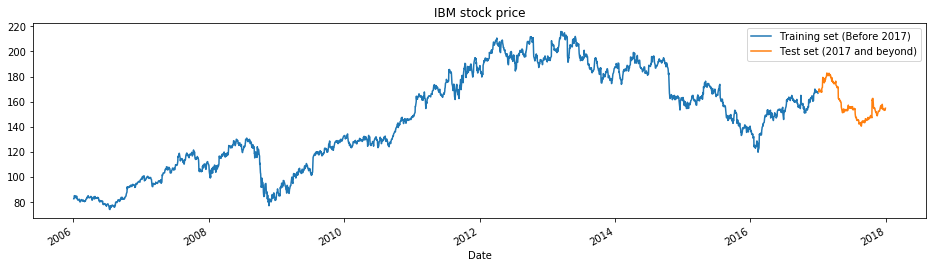

In [21]:
dataset["High"][:'2016'].plot(figsize=(16,4),legend=True)
dataset["High"]['2017':].plot(figsize=(16,4),legend=True)
plt.legend(['Training set (Before 2017)','Test set (2017 and beyond)'])
plt.title('IBM stock price')
plt.show()

In [22]:
sc = MinMaxScaler(feature_range=(0,1))
training_set_scaled = sc.fit_transform(training_set)

In [23]:
X_train = []
y_train = []
for i in range(60,2769):
    X_train.append(training_set_scaled[i-60:i,0])
    y_train.append(training_set_scaled[i,0])
X_train, y_train = np.array(X_train), np.array(y_train)

In [24]:
X_train.shape

(2709, 60)

In [25]:
y_train.shape

(2709,)

In [26]:
X_train = np.reshape(X_train, (X_train.shape[0],X_train.shape[1],1))

In [27]:
X_train.shape

(2709, 60, 1)

In [28]:
# The LSTM architecture
regressor = Sequential()
# First LSTM layer with Dropout regularisation
regressor.add(LSTM(units=50, return_sequences=True, input_shape=(X_train.shape[1],1)))
regressor.add(Dropout(0.2))
# Second LSTM layer
regressor.add(LSTM(units=50, return_sequences=True))
regressor.add(Dropout(0.2))
# Third LSTM layer
regressor.add(LSTM(units=50, return_sequences=True))
regressor.add(Dropout(0.2))
# Fourth LSTM layer
regressor.add(LSTM(units=50))
regressor.add(Dropout(0.2))
# The output layer
regressor.add(Dense(units=1))

# Compiling the RNN
regressor.compile(optimizer='rmsprop',loss='mean_squared_error')
# Fitting to the training set
regressor.fit(X_train,y_train,epochs=50,batch_size=32)

Epoch 1/50
2709/2709 [==============================] - 17s 6ms/step - loss: 0.0262
Epoch 2/50
2709/2709 [==============================] - 14s 5ms/step - loss: 0.0113
Epoch 3/50
2709/2709 [==============================] - 14s 5ms/step - loss: 0.0084
Epoch 4/50
2709/2709 [==============================] - 14s 5ms/step - loss: 0.0075
Epoch 5/50
2709/2709 [==============================] - 14s 5ms/step - loss: 0.0061
Epoch 6/50
2709/2709 [==============================] - 14s 5ms/step - loss: 0.0056
Epoch 7/50
2709/2709 [==============================] - 14s 5ms/step - loss: 0.0053
Epoch 8/50
2709/2709 [==============================] - 14s 5ms/step - loss: 0.0048
Epoch 9/50
2709/2709 [==============================] - 14s 5ms/step - loss: 0.0043
Epoch 10/50
2709/2709 [==============================] - 14s 5ms/step - loss: 0.0040
Epoch 11/50
2709/2709 [==============================] - 14s 5ms/step - loss: 0.0038
Epoch 12/50
2709/2709 [==============================] - 14s 5ms/step - lo

In [29]:
dataset_total = pd.concat((dataset["High"][:'2016'],dataset["High"]['2017':]),axis=0)

In [33]:
inputs = dataset_total[len(dataset_total)-len(test_set) - 60:].values

In [36]:
inputs = inputs.reshape(-1,1)
inputs  = sc.transform(inputs)

In [37]:
X_test = []
for i in range(60,311):
    X_test.append(inputs[i-60:i,0])
X_test = np.array(X_test)
X_test = np.reshape(X_test, (X_test.shape[0],X_test.shape[1],1))
predicted_stock_price = regressor.predict(X_test)
predicted_stock_price = sc.inverse_transform(predicted_stock_price)

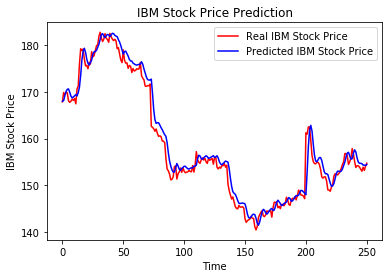

In [38]:
plot_predictions(test_set,predicted_stock_price)

In [39]:
return_rmse(test_set,predicted_stock_price)

The root mean squared error is 2.1720928042712653.


In [40]:
regressorGRU = Sequential()
# First GRU layer with Dropout regularisation
regressorGRU.add(GRU(units=50, return_sequences=True, input_shape=(X_train.shape[1],1), activation='tanh'))
regressorGRU.add(Dropout(0.2))
# Second GRU layer
regressorGRU.add(GRU(units=50, return_sequences=True, input_shape=(X_train.shape[1],1), activation='tanh'))
regressorGRU.add(Dropout(0.2))
# Third GRU layer
regressorGRU.add(GRU(units=50, return_sequences=True, input_shape=(X_train.shape[1],1), activation='tanh'))
regressorGRU.add(Dropout(0.2))
# Fourth GRU layer
regressorGRU.add(GRU(units=50, activation='tanh'))
regressorGRU.add(Dropout(0.2))
# The output layer
regressorGRU.add(Dense(units=1))
# Compiling the RNN
regressorGRU.compile(optimizer=SGD(lr=0.01, decay=1e-7, momentum=0.9, nesterov=False),loss='mean_squared_error')
# Fitting to the training set
regressorGRU.fit(X_train,y_train,epochs=50,batch_size=150)

Epoch 1/50
2709/2709 [==============================] - 6s 2ms/step - loss: 0.1553
Epoch 2/50
2709/2709 [==============================] - 4s 1ms/step - loss: 0.0586
Epoch 3/50
2709/2709 [==============================] - 4s 1ms/step - loss: 0.0280
Epoch 4/50
2709/2709 [==============================] - 4s 1ms/step - loss: 0.0062
Epoch 5/50
2709/2709 [==============================] - 4s 2ms/step - loss: 0.0043
Epoch 6/50
2709/2709 [==============================] - 4s 1ms/step - loss: 0.0038
Epoch 7/50
2709/2709 [==============================] - 4s 1ms/step - loss: 0.0035
Epoch 8/50
2709/2709 [==============================] - 4s 1ms/step - loss: 0.0032
Epoch 9/50
2709/2709 [==============================] - 4s 1ms/step - loss: 0.0034
Epoch 10/50
2709/2709 [==============================] - 4s 1ms/step - loss: 0.0031
Epoch 11/50
2709/2709 [==============================] - 4s 1ms/step - loss: 0.0032
Epoch 12/50
2709/2709 [==============================] - 4s 1ms/step - loss: 0.0030
E

In [41]:
X_test = []
for i in range(60,311):
    X_test.append(inputs[i-60:i,0])
X_test = np.array(X_test)
X_test = np.reshape(X_test, (X_test.shape[0],X_test.shape[1],1))
GRU_predicted_stock_price = regressorGRU.predict(X_test)
GRU_predicted_stock_price = sc.inverse_transform(GRU_predicted_stock_price)

In [42]:
return_rmse(test_set,GRU_predicted_stock_price)

The root mean squared error is 3.281989020555991.
